In [36]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def wrap(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return val*180/np.pi

def initialize(planets, resonances):
    t, e, P, pomega, longitude, Pratio, phi1, phi2 = {}, {}, {}, {}, {}, {}, {}, {}

    for label in planets:
        t[label] = []
        e[label] = []
        P[label] = []
        pomega[label] = []
        longitude[label] = []

    for pair in resonances.keys():
        t[pair] = []
        Pratio[pair] = []
        phi1[pair] = []
        phi2[pair] = []
        
    return t, e, P, pomega, longitude, Pratio, phi1, phi2

def output(sim,planets,resonances,t,e,P,pomega,longitude,Pratio,phi1,phi2):
    ps = sim.particles
    for p in planets:
        try:
            e[p].append(ps[p].e)
            P[p].append(ps[p].P)
            pomega[p].append(ps[p].pomega)
            longitude[p].append(ps[p].l)  
            t[p].append(sim.t)
        except:
            pass
    for resonance in resonances.items():
        pair = resonance[0]
        p1 = pair[0]
        p2 = pair[1]
        try:
            Pratio[pair].append(ps[p2].P/ps[p1].P)
            t[pair].append(sim.t)
            if resonance[1] is not None:
                res = resonance[1]
                p = res[1]
                q = res[0]-res[1]
                phi1[pair].append(wrap((p+q)*ps[p2].l - p*ps[p1].l - q*ps[p2].pomega))
                phi2[pair].append(wrap((p+q)*ps[p2].l - p*ps[p1].l - q*ps[p1].pomega))
        except:
            pass
        
def plotsa(sa,planets, resonances):
    Nout = len(sa)
    N = sa[0].N
    t, e, P, pomega, longitude, Pratio, phi1, phi2 = initialize(planets, resonances)
        
    for i,sim in enumerate(sa):
        output(sim,planets,resonances,t,e,P,pomega,longitude,Pratio,phi1,phi2)
        
    fig, axarr = plt.subplots(ncols=2, nrows=3, figsize=(18,10))
    for p in planets:
        axarr[0,0].plot(t[p], P[p], '.', label=p)
        axarr[0,1].plot(t[p], e[p], '.', label=p)
    for resonance in resonances.items():
        pair = resonance[0]
        res = resonance[1]
        axarr[1,0].plot(t[pair], Pratio[pair], '.', label=pair)
        if res is not None:
            resratio = res[0]/res[1]
            axarr[1,1].plot(t[pair], np.array(Pratio[pair])-resratio, '.', label=pair)
            axarr[2,0].plot(t[pair], phi1[pair], '.', label=pair)
            axarr[2,1].plot(t[pair], phi2[pair], '.', label=pair)
            axarr[2,0].set_ylim([0.,360])
            axarr[2,1].set_ylim([0.,360])
    for ax in axarr.flatten():
        ax.legend(loc='upper right')
    return fig

def integrate(sim, T, t, e, P, pomega, longitude, Pratio, phi1, phi2, planets, resonances):
    Nout = 1000
    T0 = sim.t
    times = np.linspace(T0, T0+T, Nout)
    ps = sim.particles
    for i, time in enumerate(times):
        sim.integrate(time)
        output(sim,planets,resonances,t,e,P,pomega,longitude,Pratio,phi1,phi2)
        
def plot(t,P,e,Pratio,phi1,phi2,planets,resonances):
    fig, axarr = plt.subplots(ncols=2, nrows=3, figsize=(18,10))
    for p in planets:
        axarr[0,0].plot(t[p], P[p], '.', label=p)
        axarr[0,1].plot(t[p], e[p], '.', label=p)
    for resonance in resonances.items():
        pair = resonance[0]
        res = resonance[1]
        axarr[1,0].plot(t[pair], Pratio[pair], '.', label=pair)
        if res is not None:
            resratio = res[0]/res[1]
            axarr[1,1].plot(t[pair], np.array(Pratio[pair])-resratio, '.', label=pair)
            axarr[2,0].plot(t[pair], phi1[pair], '.', label=pair)
            axarr[2,1].plot(t[pair], phi2[pair], '.', label=pair)
            axarr[2,0].set_ylim([0.,360])
            axarr[2,1].set_ylim([0.,360])
    for ax in axarr.flatten():
        ax.legend(loc='upper right')
    return fig

In [11]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
from numpy.random import seed, normal, uniform

def wrap(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return val*180/np.pi

def output(sim,planets,resonances,threebodyresonances,t,e,P,pomega,longitude,Pratio,phi1,phi2,deltapomega,phi3body):
    ps = sim.particles
    for p in planets:
        try:
            e[p].append(ps[p].e)
            P[p].append(ps[p].P)
            pomega[p].append(ps[p].pomega)
            longitude[p].append(ps[p].l)  
            t[p].append(sim.t)
        except:
            pass
    for resonance in resonances.items():
        pair = resonance[0]
        p1 = pair[0]
        p2 = pair[1]
        try:
            Pratio[pair].append(ps[p2].P/ps[p1].P)
            t[pair].append(sim.t)
            if resonance[1] is not None:
                res = resonance[1]
                p = res[1]
                q = res[0]-res[1]
                phi1[pair].append(wrap((p+q)*ps[p2].l - p*ps[p1].l - q*ps[p2].pomega))
                phi2[pair].append(wrap((p+q)*ps[p2].l - p*ps[p1].l - q*ps[p1].pomega))
                deltapomega[pair].append(wrap(ps[p2].pomega - ps[p1].pomega))
        except:
            pass
        
    for resonance in threebodyresonances.items():
        triad = resonance[0]
        p1 = triad[0]
        p2 = triad[1]
        p3 = triad[2]
        res = resonance[1]
        p = res[0]
        q = res[1]
        try:
            phi3body[triad].append(wrap(p*ps[p1].l - (p+q)*ps[p2].l + q*ps[p3].l))
            t[triad].append(sim.t)
        except:
            pass
        
def plot(t,P,e,Pratio,phi1,phi2,deltapomega,phi3body,planets,resonances,threebodyresonances):
    fig, axarr = plt.subplots(ncols=2, nrows=4, figsize=(18,10))
    for p in planets:
        axarr[0,0].plot(t[p], P[p], '.', label=p)
        axarr[0,1].plot(t[p], e[p], '.', label=p)
    for resonance in resonances.items():
        pair = resonance[0]
        res = resonance[1]
        axarr[1,0].plot(t[pair], Pratio[pair], '.', label=pair)
        if res is not None:
            resratio = res[0]/res[1]
            axarr[1,1].plot(t[pair], np.array(Pratio[pair])-resratio, '.', label=pair)
            axarr[2,0].plot(t[pair], phi1[pair], '.', label=pair)
            axarr[2,1].plot(t[pair], phi2[pair], '.', label=pair)
            axarr[3,0].plot(t[pair], deltapomega[pair], '.', label=pair)
            axarr[2,0].set_ylim([0.,360])
            axarr[2,1].set_ylim([0.,360])
    for resonance in threebodyresonances.items():
        triad = resonance[0]
        axarr[3,1].plot(t[triad], phi3body[triad], '.', label=triad)
    
    for ax in axarr.flatten():
        ax.legend(loc='upper right')
    return fig

def removedamping(sim, Tremoval, K, t, e, P, pomega, longitude, Pratio, phi1, phi2, planets, resonances): # Tremovel in # of taue0s
    ps = sim.particles
    taue0 = ps[-1].params["tau_e"]
    T0 = sim.t
    print(T0)
    T = abs(taue0)*Tremoval
    Nout = 1000
    times = np.linspace(T0, T0+T, Nout)
    
    for i, time in enumerate(times):
        for p in ps[1:]:
            p.params["tau_e"] = taue0/(1.-(sim.t-T0)/T)
            try: # try except so we don't assign a tau_a to planets that don't have it
                has_tau_a = p.params["tau_a"]
                p.params["tau_a"] = taue0*K/(1.-(sim.t-T0)/T)
            except:
                pass
        sim.integrate(time)
        output(sim,planets,resonances,t,e,P,pomega,longitude,Pratio,phi1,phi2)
        
    for p in ps[1:]:
        p.params["tau_e"] = np.inf
        p.params["tau_a"] = np.inf

def integrate(sim, T, t, e, P, pomega, longitude, Pratio, phi1, phi2, deltapomega, phi3body, planets, resonances, threebodyresonances):
    Nout = 1000
    T0 = sim.t
    times = np.linspace(T0, T0+T, Nout)
    ps = sim.particles
    for i, time in enumerate(times):
        sim.integrate(time)
        output(sim,planets,resonances,threebodyresonances,t,e,P,pomega,longitude,Pratio,phi1,phi2,deltapomega,phi3body)
        
def initialize(planets, resonances, threebodyresonances):
    t, e, P, pomega, longitude, Pratio, phi1, phi2, deltapomega, phi3body = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}

    for label in planets:
        t[label] = []
        e[label] = []
        P[label] = []
        pomega[label] = []
        longitude[label] = []

    for pair in resonances.keys():
        t[pair] = []
        Pratio[pair] = []
        phi1[pair] = []
        phi2[pair] = []
        deltapomega[pair] = []
        
    for triad in threebodyresonances.keys():
        t[triad] = []
        phi3body[triad] = []
        
    return t, e, P, pomega, longitude, Pratio, phi1, phi2, deltapomega, phi3body

In [12]:
planets = ['b', 'c', 'd', 'e', 'f', 'g', 'h']
resonances = OrderedDict([(('b','c'),(8,5)),(('c','d'),(5,3)),(('d','e'),(3,2)),(('e','f'),(3,2)),(('f','g'),(4,3)),(('g','h'),(3,2))]) # ordered so we add planets in right sequence
threebodyresonances = OrderedDict([(('b','c','d'),(2,3)),(('c','d','e'),(1,2)),(('d','e','f'),(2,3)),(('e','f','g'),(1,2)),(('f','g','h'),(1,1))])

In [37]:
from collections import OrderedDict
planets = ['b', 'c', 'd', 'e', 'f', 'g']
resonances = OrderedDict([(('d','e'),(3,2)),(('e','f'),(3,2)),(('f','g'),(4,3))]) # ordered so we add planets in right sequence

IC1K6.8241e+01mag3.1906e-01.bin


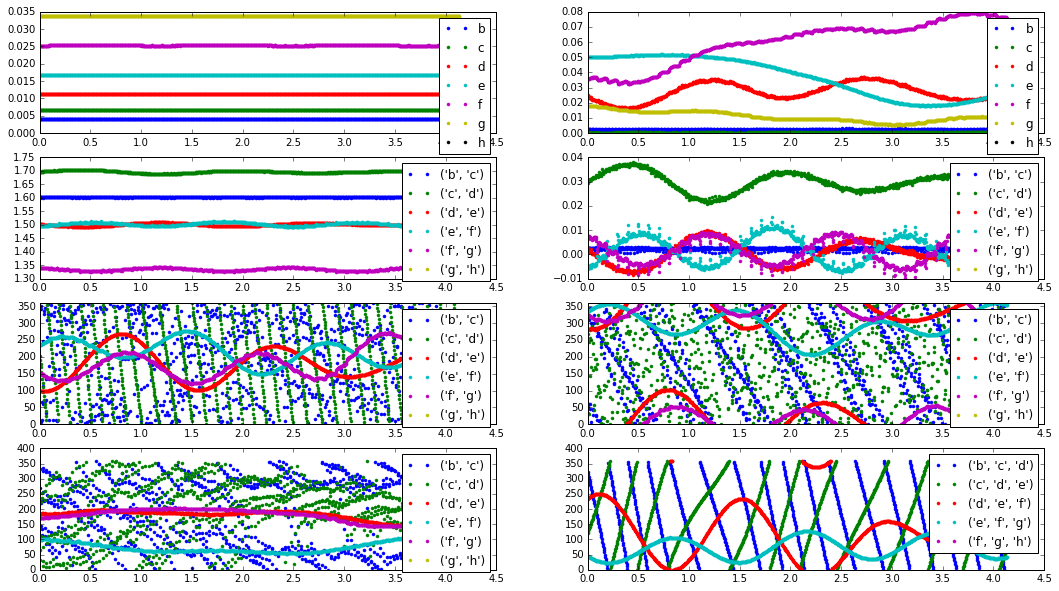

In [13]:
simID=1
import os
for filename in os.listdir('data/'):
    if filename.startswith("IC{0}K".format(simID)):
        print(filename)
        sa = rebound.SimulationArchive('data/'+filename)

sim = sa[0]
t, e, P, pomega, longitude, Pratio, phi1, phi2, deltapomega, phi3body = initialize(planets, resonances, threebodyresonances)
  
integrate(sim, 1.e3*sim.particles[1].P, t, e, P, pomega, longitude, Pratio, phi1, phi2, deltapomega, phi3body, planets, resonances,threebodyresonances)
plot(t,P,e,Pratio,phi1,phi2,deltapomega,phi3body,planets,resonances,threebodyresonances);

In [104]:
simID=110
import os
for filename in os.listdir('data/'):
    if filename.startswith("IC{0}K".format(simID)):
        print(filename)
        sim = rebound.Simulation.from_archive('data/'+filename)
        print(sim.t)

IC110K1.7065e+01mag5.6081e-03.bin
3000.0001176906135
